**Modeling**

The purpose of this workbook is to set up a collection of models to test out-of-the-box performance, then to tune hyperparameters for several of the models. At the end, we will compare the performance of the top candidates and select one as our final model.

The models we'll compare are:
- multiple linear regression
- knn regression
- random forest
- support vector
- gradient boost
- adaboost
- xgboost 

Like in the Kaggle competition, performance will be measured using Cohen's kappa.

Our target variable is sii. However, in the original data set, sii was computed from adding the twenty PCIAT variables and then grouping the total into bins. So we can try three different ways of evaluating the performance of these models:
* Predicting sii directly
* First predicting PCIAT_Total, then computing sii using the "official" bins
* Adjusting the bins we use to compute sii

We will also write an "ordinal classifier" wrapper (imported from an external file) as a "wrapper" for several models and compare their performance.

After comparing out-of-the-box performance of the various models, we will try tuning several of the models and then comparing the OOTB and tuned versions of the best-performing models

In [1]:
import pandas as pd
import numpy as np

# CustomImputers includes two imputers (using KNN and interative imputing) for this dataset
# and also two functions to transform fitnessgram values into fitnessgram zones, and to round sii values
from CustomImputers import *

**Loading the Data and Creating Lists**

In this section, we'll load the data (cleaned, with unnecessary features already removed) and create lists of predictors based on previous exploration

For the purpose of developing our model(s), we'll work with data that include the imputed outcome (PCIAT_Total and/or sii) scores AND have cleaned predictors.

In the final version of our code (which we'll submit to Kaggle), we'll work with data with cleaned predictors but won't have any access to the outcome scores.

In [2]:
#Load the cleaned & outcome-imputed data
train_cleaned=pd.read_csv('train_cleaned_outcome_imputed_feature_selected.csv')

In [3]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

# Create an augmented list that will be used for 
predictors_plus = predictors + ['PCIAT-PCIAT_Total']

# Create a list of "key features" based on work in the Feature Selection notebook
keyfeatures = ['Basic_Demos-Age',
 'Physical-Height',
 'PreInt_EduHx-computerinternet_hoursday',
 'BIA-BIA_FFM',
 'SDS-SDS_Total_Raw',
 'Physical-Weight',
 'ENMO_Avg_Active_Days_MVPA110',
 'FGC-FGC_CU']

# The Fitness_Endurance predictor was creating havoc with the MLR models, so we'll omit it from the predictor list for those models
predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]

**Trying a Linear Model**

In this section, I'll make a linear model with a single predictor (hours spent on the internet)

Note: Column selector documented here: https://stackoverflow.com/questions/62416223/how-to-select-only-few-columns-in-scikit-learn-column-selector-pipeline

In [6]:
# First I'll see if I can get a pipe set up to do prediction on a split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

# Split the data into train and test
train_tt, train_ho = train_test_split(train_cleaned, test_size=0.2)

# Impute and compute values for the train and test sets
mice = Custom_MICE_Imputer()
train_tt = mice.fit_transform(train_tt)
train_tt = zone_encoder(train_tt)
train_ho = mice.fit_transform(train_ho)
train_ho = zone_encoder(train_ho)

# Set up SMOTE to create 128 (rather than 32) instances of sii=3 while keeping the other counts the same
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)
X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

# Create pipes/models for single and multiple linear regression
slr = Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())])

mlr = LinearRegression()

# Fit and make predictions
slr.fit(X[predictors], X['PCIAT-PCIAT_Total'])
print('SLR MSE:', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], slr.predict(train_ho)))

mlr.fit(X[predictors], X['PCIAT-PCIAT_Total'])
print('MLR MSE:', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], mlr.predict(train_ho[predictors])))

# The code below is meant to identify which predictor might be inflating the MLR
templist = []
for item in predictors:
    templist = templist + [item]
    mlr.fit(X[templist], X['PCIAT-PCIAT_Total'])
    print('MLR MSE after adding',item,'is', mean_squared_error(train_ho['PCIAT-PCIAT_Total'], mlr.predict(train_ho[templist])))


SLR MSE: 343.0355615764681
MLR MSE: 5917.7087538693795
MLR MSE after adding Basic_Demos-Age is 360.28860892976917
MLR MSE after adding Basic_Demos-Sex is 357.85598178707306
MLR MSE after adding CGAS-CGAS_Score is 357.48465633211987
MLR MSE after adding Physical-BMI is 357.17851471911985
MLR MSE after adding Physical-Height is 356.73168613893006
MLR MSE after adding Physical-Weight is 356.6232170703393
MLR MSE after adding Physical-Waist_Circumference is 355.9531351099258
MLR MSE after adding Physical-Diastolic_BP is 355.8744058895502
MLR MSE after adding Physical-HeartRate is 357.1000861457026
MLR MSE after adding Physical-Systolic_BP is 359.1918572416056
MLR MSE after adding FGC-FGC_CU is 361.74734194713284
MLR MSE after adding FGC-FGC_PU is 362.5288001227467
MLR MSE after adding FGC-FGC_TL is 364.5251985145941
MLR MSE after adding BIA-BIA_Activity_Level_num is 364.3621408764233
MLR MSE after adding BIA-BIA_FFM is 361.9976809076499
MLR MSE after adding BIA-BIA_FFMI is 369.063579236326

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**Comparing Models for Out-of-the-Box Performance**

**Part 1: Setting Up Models**

In the sections below, we'll set up a collection of un-tuned models and use them to predict sii scores. 

This first section instantiates the various models inside a dictionary that we'll use in the loop.

Note that we **aren't** using SMOTE here because we're (sometimes) going to predict PCIAT-PCIAT_Total rather than sii, and we want SMOTE to generate synthetic points based on sii.

Later, when we just want to predict sii, we can incorporate SMOTE into the pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier

#Import our custom Ordinal Classifier wrapper
from OrdinalClassifier import *

# If we were including SMOTE in the pipeline, we'd need a different import statement
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

# Create classifiers to use as inputs to ordinal classifiers

# Note that the logistic regression is failing to converge.
# This can be addressed - see https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
# Here we're increasing max_iter from its default and also adding a standard scaler into its pipeline
# We could also adjust the solver, ad described here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
logisticc = LogisticRegression(max_iter=1000)

knnc=KNeighborsClassifier(10)
svc = SVC()
rfc = RandomForestClassifier()
# Note that the default for adaboost is the SAMME.R algorithm, but this will be deprecated in future releases. Switching to SAMME
adac = AdaBoostClassifier(algorithm='SAMME')
gradc = GradientBoostingClassifier()
xgbc = XGBClassifier()

#Note - for some reason, including Fitness_Endurance in MLR tanks its performance, so we'll leave it out of the predictors for MLR
predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]


# List the various models we'll try to identify their "out of the box" performance
models = {
'slr_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_key_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_all_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', predictors_less)], remainder="drop")),
                ('linear', LinearRegression())]),

'knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn', KNeighborsRegressor(10))]),

'svr' : SVR(),

'rf': RandomForestRegressor(),

'ada' : AdaBoostRegressor(),

'grad' : GradientBoostingRegressor(),

'xgb': XGBRegressor(),

'ordinal_logistic_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('logistic_oc', OrdinalClassifier(logisticc))]),

'ordinal_knn_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('knn_ordinal', OrdinalClassifier(knnc))]),

# Note that SVC doesn't have a predict_proba method. This can be manually added later in a custom classifier; removing for now to facilitate completion...
#'ordinal_svc_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
#                ('add_zones', FunctionTransformer(zone_encoder)),
#                ('svc_ordinal', OrdinalClassifier(svc))]),

'ordinal_rf' : OrdinalClassifier(rfc),

'ordinal_ada' : OrdinalClassifier(adac),

'ordinal_grad': OrdinalClassifier(gradc),

'ordinal_xgb': OrdinalClassifier(xgbc)

}

**Comparing Models for Out-of-the-Box Performance**

**Part 2: Evaluating Models**

The second section runs the models through a 5-fold split to compute kappa values.

We can predict sii scores in two ways:
1. Predict the PCIAT_Total score and then compute sii values
2. Predict the sii score directly

We can also modify some of these computations by adjusting the bins for computing sii values and by adjusting the computed sii scores manually.

Note: Column selector documented here: https://stackoverflow.com/questions/62416223/how-to-select-only-few-columns-in-scikit-learn-column-selector-pipeline

**Oversampling Minority Classes**

One issue here is the extremely small number of sii=3 values in our data set: specifically, there are only 32 such instances in the dataset. This will make it difficult for models to predict an outcome of sii=3.

We'll use SMOTE to create additional "synthetic" samples with sii=3 (see 
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In short, SMOTE looks at the cases where sii=3, uses KNN to identify the five "nearest" cases, randomly selects one of these neighbors, and creates a new case where sii=3 by averaging the values of this selected neighbor with the actual sii=3 case.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Set up a list of the models and methods to organize the computation of means in the kfold split
modellist = []
for pipeline_name, pipeline_obj in models.items():
    modellist.append(pipeline_name)

methodlist = ['Compute SII from PCIAT (Standard Bins) (kappa)', 
                'Compute SII from PCIAT (Modified Bins) (kappa)',
                'Predict SII (rounded) (kappa)']

num_splits = 5

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((len(methodlist), len(modellist), num_splits))

#Make a StratifiedKFold object stratified by the variable sii
# This is necessary due to the small number of sii=3 values
kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0
for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    #Use our custom imputer and transformer to impute/compute necessary predictors
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    # Use SMOTE to oversample the sii=3 minority class
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    # j will enumerate the model
    j=0

    for pipeline_name, pipeline_obj in models.items():
        # The ordinal predictors can't predict PCIAT scores, so we'll leave them out of the first round of computations
        if 'ordinal' in pipeline_name:
            kappa_sii_comp = 0
            kappa_sii_comp_mod = 0
        else:
            # Fit and make predictions of PCIAT_Total
            pipeline_obj.fit(X[predictors_less], X['PCIAT-PCIAT_Total'])
            pred = pipeline_obj.predict(train_ho[predictors_less])

            # Compute sii based on PCIAT
            bins = [0, 30, 49,79,100]
            pred_bin = np.digitize(pred, bins)-1

            # Try a slightly different set of bins suggested by the "tuning" below
            bins_mod = [0, 27, 39, 79, 100]
            pred_bin_mod = np.digitize(pred, bins_mod)-1

            # Compute kappa values
            kappa_sii_comp = cohen_kappa_score(train_ho['sii'], pred_bin, weights='quadratic')
            kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
        
        # Store the kappa values in the output array
        output[0,j,i] = kappa_sii_comp
        output[1,j,i] = kappa_sii_comp_mod
        j=j+1

    j=0
    for pipeline_name, pipeline_obj in models.items():
        # Fit and make predictions of sii
        pipeline_obj.fit(X[predictors], y)
        pred = pipeline_obj.predict(train_ho[predictors])

        # Round the predictors to compute kappa
        pred_round = np.round(pred)

        # Compute and record the kappa values
        kappa_sii_round = cohen_kappa_score(train_ho['sii'], pred_round, weights='quadratic')

        output[2,j,i] = kappa_sii_round
        j=j+1
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_avg = np.mean(output, axis=2)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [8]:
# create a data frame from output using modellist as the names of the columns and methodlist as the names of the rows
output_df = pd.DataFrame(output_avg, columns=modellist, index=methodlist)

output_df

,slr_pipe,mlr_key_pipe,mlr_all_pipe,knn_pipe,svr,rf,ada,grad,xgb,ordinal_logistic_pipe,ordinal_knn_pipe,ordinal_rf,ordinal_ada,ordinal_grad,ordinal_xgb
Compute SII from PCIAT (Standard Bins) (kappa),0.255586,0.420277,0.417688,0.371806,0.285835,0.407872,0.383164,0.405178,0.378211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Compute SII from PCIAT (Modified Bins) (kappa),0.320950,0.451147,0.449815,0.393062,0.349600,0.441952,0.427930,0.450957,0.394311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Predict SII (rounded) (kappa),0.279026,0.407338,0.402916,0.372991,0.325849,0.354275,0.166847,0.394077,0.332422,0.393088,0.306073,0.323828,0.333468,0.418456,0.382866


**Results of OOtB Investigation**

* The multiple regression - both using all predictors and using just the "key" features had among the largest kappa values.
* Gradient Boosting - both as a regressor and inside an ordinal classifier - was at or near the top of kappa values.
* Logistic regression inside an ordinal classifier did well
* Random forest performed decently for predicting PCIAT scores and then computing sii values
* XGBoost performed decently for predicting sii values both via regression and inside an ordinal classifier.
* Adaboost performed well for predicting PCIAT, but not for predicting sii

Predicting PCIAT and then computing sii benefitted from adjusting the cutpoints.

In the sections below, we'll "tune" the cutpoints and then try tuning a few of the models and re-testing the loop.

**Tuning the Bins**

We noticed that our model struggled to predict higher output values.

When we adjusted the values for converting PCIAT scores to sii scores, we noticed an improvement in prediction when we lowered the cutpoints.

We sought to "tune" these cutpoints. However, we need to be mindful of overfitting. 

We'll look at the combination of cutpoints that maximize kappa, and then from the top 20 (or so) select the cutpoints that are closest to the original ones (as measured by euclidean distance)

In [ ]:
# We'll use the multiple linear regression with "key" features to test the cutpoints
# This model performed as good or better than most of the other (untuned) models
# Since it is quick to run, it should be a decent choice for doing this tuning

# Start by setting up the MLR pipeline
mlr_key_pipe=Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())])

# Set the number of k-fold splits
num_splits = 5

# Set the number of different cutpoints to try
num_bincuts=15

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((num_bincuts, num_bincuts,num_bincuts, num_splits))

#Make a KFold object, stratified on sii=3 values
kfold= StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0

for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    # Compute and impute
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    #Oversample with SMOTE
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    
    # Fit the pipe and make predictions
    mlr_key_pipe.fit(train_tt[predictors], train_tt['PCIAT-PCIAT_Total'])
    pred = mlr_key_pipe.predict(train_ho[predictors])

    # Iterate through values of the three cutpoints    
    for r in range(num_bincuts):
        for s in range(num_bincuts):
            for t in range(num_bincuts):
                bins = [0, 30-r, 49-s,79-t,100]
                pred_bin_mod = np.digitize(pred, bins)-1
                # Compute kappa for the binned predictions
                kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
                output[r,s,t,i]=kappa_sii_comp_mod
                
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_avg = np.mean(output, axis=3)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Next, we'll examine the output of the tuning

In [201]:
# Flatten the array and sort the indices in descending order
sorted_indices_flat = np.argsort(output_avg.ravel())[::-1]

#Decide how many top values you want to look at. 
n=20

# Get the flat indices of the top two values
top_flat_indices = sorted_indices_flat[:n]

# Convert the flat indices to 3D indices
top_indices = [np.unravel_index(idx, output_avg.shape) for idx in top_flat_indices]

# Retrieve the top two values
top_values = output_avg.ravel()[top_flat_indices]

print("Top values:", top_values)
print("Locations of the top values:", top_indices)

Top values: [0.46093949 0.46093949 0.46093949 0.46093949 0.4605503  0.4605503
 0.4605503  0.4605503  0.4605503  0.4605503  0.4605503  0.4605503
 0.4605503  0.4605503  0.4605503  0.46037258 0.46037258 0.46037258
 0.46037258 0.46005213]
Locations of the top values: [(4, 11, 13), (4, 11, 11), (4, 11, 14), (4, 11, 12), (4, 11, 0), (4, 11, 1), (4, 11, 2), (4, 11, 3), (4, 11, 4), (4, 11, 5), (4, 11, 7), (4, 11, 8), (4, 11, 9), (4, 11, 10), (4, 11, 6), (3, 11, 14), (3, 11, 13), (3, 11, 12), (3, 11, 11), (4, 10, 14)]


**Results of Cutpoint Tuning**

We ran the code above, looked at the top 20 (in terms of kappa) sets of cutpoints, and selected the combination of cutpoints that minimized the Euclidean distance to the original cutpoints. Then we repeated this two more times. The results were:

* First time: [0, 30-3, 49-6,79-8,100] = [0, 27, 43, 71, 100]
* Second time: [0, 30-3, 49-11,79-0,100] = [0, 27, 38, 79, 100]
* Third time: [0, 30-3, 49-10,79-0,100] = [0, 27, 39, 79, 100]

We'll use this third set of cutpoints.

**Hyperparameter Tuning**

The models above were run "out of the box." In the next sections, we'll try to tune a few of them (random forest, gradient boost, and logistic regression inside an ordinal classifier) to see how much we can improve their performance.

**Tuning the Random Forest Regressor**

In this section, we'll tune the random forest regressor.

Note that using a pipeline with gridcvsearch requires slightly different naming conventions for the parameter grid: 
https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Below is the initial parameter grid we're trying
param_grid = {
    'rf__n_estimators': [50, 100, 200, 500],
    'rf__max_depth': range(1,10),
    'rf__min_samples_split': [2, 4, 8]
}

#Below is the last round of parameters we're trying after several iterations
#param_grid = {
#    'rf__n_estimators': [90, 95, 100, 105, 110],
#    'rf__max_depth': [6],
#    'rf__min_samples_split': [4]
#}

# Instantiate a random forest pipeline
rf_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('rf', RandomForestRegressor())])

grid_cv_rf = GridSearchCV(rf_pipe, 
                          param_grid = param_grid, 
                          cv = 5,
                          return_train_score=True)

# We'll start by tuning on PCIAT, and can tune separately on sii
grid_cv_rf.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x305cc5800>)),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': range(1, 10),
                         'rf__min_samples_split': [2, 4, 8],
                         'rf__n_estimators': [50, 100, 200, 500]},
             return_train_score=True)

In [17]:
# Report the results
print('Best parameters:',grid_cv_rf.best_params_)
print('Best score:',grid_cv_rf.best_score_)

Best parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 4, 'rf__n_estimators': 200}
Best score: 0.28041971572948254


**Results from GridSearch for Random Forest Regressor**

The first run took 30 minutes using the following parameter grid:
* 'rf__n_estimators': [50, 100, 200, 500],
* 'rf__max_depth': range(1,10),
* 'rf__min_samples_split': [2, 4, 8]

The best parameters, achieving a score of 0.28379 were:
* max_depth: 6
* min_samples_split: 4
* n_estimators: 100

(When run again, we got a score of 0.280419 using [5, 4, 200])

The second run took 4 minutes, using a narrower ranges of parameters:
* 'rf__n_estimators': [75, 100, 150],
* 'rf__max_depth': range(4,7),
* 'rf__min_samples_split': [3, 4, 5]

The best parameters, achieving a score of 0.28396 were:
* max_depth: 6
* min_samples_split: 4
* n_estimators: 100

We will try one more search, further narrowing the ranges:
* 'rf__n_estimators': [90, 95, 100, 105, 110],
* 'rf__max_depth': [6],
* 'rf__min_samples_split': [4]

The best parameters, achieving a score of 0.2812376 were:
* n_estimators: 105

We noticed that this score was lower than the previous run, so we tried re-running. This time, the best parameters, achieving a score of 0.280982 were:
* n_estimators: 110

A third run yielded a score of 0.2808725 with
* n_estimators: 95

So it seems like the original set of best parameters (6, 4, 100) will likely work fine for us.

**Checking Random Forest (for PCIAT) for Overfitting**

We can look at the mean_train_scores and mean_test_scores reported for each of the combinations of hyperparameters

In [ ]:
# Check for overfitting
# Start by getting the mean scores for the train and test

print(grid_cv_rf.cv_results_.keys())
print(grid_cv_rf.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_rf.cv_results_["mean_test_score"].shape)

print(grid_cv_rf.cv_results_["mean_train_score"])
print(grid_cv_rf.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(108,)
(108,)
[0.18390851 0.1834061  0.1848826  0.18449659 0.18404056 0.18436459
 0.18384535 0.18378982 0.18431751 0.18283691 0.18496858 0.18405515
 0.25742096 0.25823451 0.25693219 0.2580366  0.25651277 0.25735381
 0.25703056 0.2580047  0.25808027 0.25758818 0.25770655 0.25802382
 0.30977512 0.31116411 0.31120783 0.31124656 0.31087921 0.31123801
 0.31112095 0.31148983 0.31079393 0.31121341 0.31083666 0.31166513
 0.3666522  0.36872735 0.36941598 0.37005238 0.36860141 0.36930643
 0.3691513  0.36951611 0.36698516 0

Best mean_train_score: [0.43680054]
Best mean_test_score: [0.28041972]


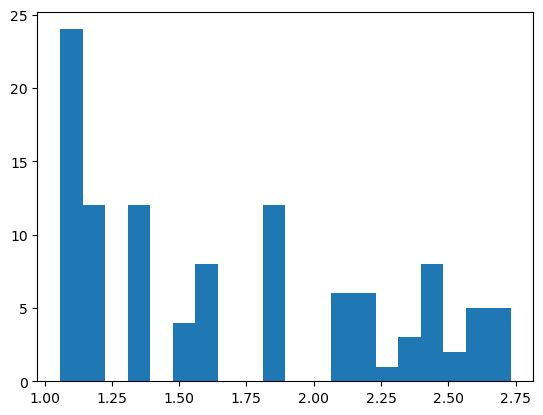

In [19]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_rf.cv_results_["mean_test_score"]==grid_cv_rf.best_score_)
print('Best mean_train_score:', grid_cv_rf.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_rf.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
rf_results_df = pd.DataFrame({'mean_train_score': grid_cv_rf.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_rf.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
rf_results_df['ratio'] = rf_results_df['mean_train_score']/rf_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = rf_results_df['ratio'].quantile(0.25)
Q3 = rf_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = rf_results_df[(rf_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (rf_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
rf_sii_results_df = rf_results_df[~rf_results_df['ratio'].isin(outliers['ratio'])]

import matplotlib.pyplot as plt

# Create a histogram of ratio
plt.hist(rf_results_df['ratio'], bins=20)
plt.show()

**Interpretation**

The ratio of train kappas to test kappas using our "best" set of parameters was 1.557666985759775. This seems like it might correspond to overfitting. But it seems in line with the (non-outlier) ratios among all tested sets of hyperparameters.

**Tuning Random Forest for Predicting sii**

In the section above, we trained a random forest regressor to predict PCIAT scores.

Next, we'll train it for sii scores. Since we are now predicting sii, we can use SMOTE as part of the pipeline.

GridSearchCV doesn't include kappa as a built-in metric. In addition, RF will use regression to predict sii scores, and these will need to be rounded.

So we'll need to make a custom scorer to evaluate the models.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer
#Importing classes to use SMOTE in a pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

#Below is the initial parameter grid we used
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': range(1,11),
    'rf__min_samples_split': [2, 4, 8]
}

#Below is the last iteration of the parameter grid we used
#param_grid = {
#    'rf__n_estimators': [50, 75, 100],
#    'rf__max_depth': range(5, 7),
#    'rf__min_samples_split': [8, 10, 12]
#}

# Instantiate a random forest pipeline
rf_pipe_sii = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('over', oversample),
                ('rf', RandomForestRegressor())])

grid_cv_rf_sii = GridSearchCV(rf_pipe_sii, 
                          param_grid = param_grid, 
                          scoring = kappa_scorer, 
                          cv = 5,
                          return_train_score = True)

grid_cv_rf_sii.fit(train_cleaned[predictors], train_cleaned['sii'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x305cc5800>)),
                                       ('over',
                                        SMOTE(sampling_strategy={0: 1228,
                                                                 1: 619, 2: 315,
                                                                 3: 128})),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': range(1, 11),
                         'rf__min_samples_split': [2, 4, 8],
                         'rf__n_estimators': [50, 100, 200]},
             return_train_score=True,
             scoring=make_scorer(sii_kappa, response_method='predict'))

In [24]:
# Report the results
print('Best parameters:',grid_cv_rf_sii.best_params_)
print('Best score:',grid_cv_rf_sii.best_score_)

Best parameters: {'rf__max_depth': 6, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score: 0.40595844368852746


**Results from GridSearch for Random Forest Regressor for sii**

The first run (done before we incorporated SMOTE) took 14 minutes using the following parameter grid:
* 'rf__n_estimators': [50, 100, 200],
* 'rf__max_depth': range(1,11),
* 'rf__min_samples_split': [2, 4, 8]

The best parameters, achieving a score of 0.36574 were:
* max_depth: 8
* min_samples_split: 8
* n_estimators: 50

On a second run with the original parameters but using SMOTE, we got a score of 0.40595 using [6, 2, 100]

The second run took 4 minutes, using a narrower ranges of parameters:
* 'rf__n_estimators': [25, 50, 75],
* 'rf__max_depth': range(5,7),
* 'rf__min_samples_split': [6, 8, 10]

The best parameters, achieving a score of 0.364877 were:
* max_depth: 6
* min_samples_split: 10
* n_estimators: 75

We will try one more search, further narrowing the ranges:
* 'rf__n_estimators': [50, 75, 100],
* 'rf__max_depth': range(5, 7),
* 'rf__min_samples_split': [8, 10, 12]

The best parameters, achieving a score of 0.3576324 were:
* max_depth: 6
* min_samples_split: 10
* n_estimators: 50

Re-running, The best parameters, achieving a score of 0.35866 were:
* max_depth: 6
* min_samples_split: 8
* n_estimators: 50

Re-running one more time WITH SMOTE, the best parameters, achieving a score of 0.40938 were
* max_depth: 5
* min_samples_split: 8
* n_estimators: 75

So it seems like the set of best parameters (5, 8, 75) will likely be ideal

**Check for Overfitting**

In [25]:
print(grid_cv_rf_sii.cv_results_.keys())
print(grid_cv_rf_sii.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_rf_sii.cv_results_["mean_test_score"].shape)

print(grid_cv_rf_sii.cv_results_["mean_train_score"])
print(grid_cv_rf_sii.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(90,)
(90,)
[0.31295261 0.31255306 0.31249781 0.31308296 0.30767403 0.30885906
 0.31278834 0.30919119 0.30732978 0.36631831 0.40238114 0.37237101
 0.38655556 0.39632033 0.39251838 0.38594886 0.3825209  0.39601109
 0.44926826 0.44868662 0.43414517 0.43681397 0.44372658 0.43765974
 0.44755988 0.44507598 0.44348152 0.48759026 0.49145322 0.49070118
 0.48684891 0.48841374 0.48845935 0.48005647 0.4960198  0.48359903
 0.55909422 0.54989074 0.55263152 0.55469487 0.55876084 0.55258538
 0.55310935 0.54989776 0.553267   0.6

Best mean_train_score: [0.62386246]
Best mean_test_score: [0.40595844]


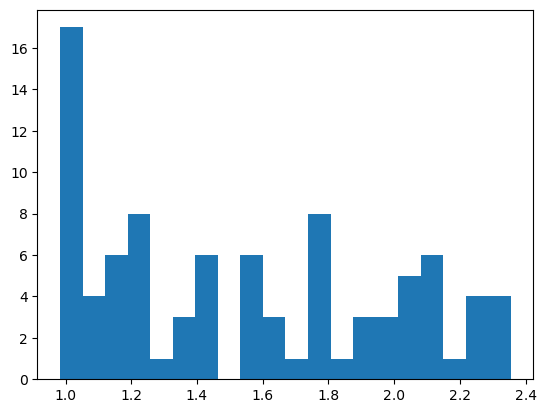

In [26]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_rf_sii.cv_results_["mean_test_score"]==grid_cv_rf_sii.best_score_)
print('Best mean_train_score:', grid_cv_rf_sii.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_rf_sii.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
rf_sii_results_df = pd.DataFrame({'mean_train_score': grid_cv_rf_sii.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_rf_sii.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
rf_sii_results_df['ratio'] = rf_sii_results_df['mean_train_score']/rf_sii_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = rf_sii_results_df['ratio'].quantile(0.25)
Q3 = rf_sii_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = rf_sii_results_df[(rf_sii_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (rf_sii_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
rf_sii_results_df = rf_sii_results_df[~rf_sii_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(rf_sii_results_df['ratio'], bins=20)
plt.show()

**Interpretation**

The ratio of train kappas to test kappas using our "best" set of parameters was 1.536. This seems like it might correspond to overfitting. But it seems in line with the (non-outlier) ratios among all tested sets of hyperparameters.

**Tuning Gradient Boosting Regressor for PCIAT**

There are lots of parameters to consider here.

We'll use some suggestions from various websites to think about a parameter grid, being mindful of the amount of time it will take to run the code.

Sources consulted:
* https://stackoverflow.com/questions/49500313/tune-parameters-in-gradient-boosting-reggression-with-cross-validation-sklearn
* https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Note that we have a total of ~2500 observations with PCIAT scores in the entire dataset, a very small (32) number of scores with sii=3 and a relatively small number of scores with sii=2. SMOTE could help with this, but we can't use it inside a pipe when we're trying to predict PCIAT. (We could do this tuning manually, but due to time constraints, we're going to stick with using GridSearchCV)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'grad__learning_rate': [0.5, 0.1, 0.05],
    'grad__max_depth': [3,5,7],
    'grad__max_features': [10, 15, 20, 25],
    'grad__min_samples_leaf': [5, 8, 11],
    'grad__min_samples_split': [3, 5, 7],
    'grad__n_estimators': [50, 100, 200]
}

# Instantiate a gradient boosting regressor pipeline
grad_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('grad', GradientBoostingRegressor())])

grid_cv_grad = GridSearchCV(grad_pipe, 
                          param_grid = param_grid, 
                          cv = 5,
                          return_train_score=True)

# We'll start by tuning on PCIAT, and can tune separately on sii
grid_cv_grad.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x305cc5800>)),
                                       ('grad', GradientBoostingRegressor())]),
             param_grid={'grad__learning_rate': [0.5, 0.1, 0.05],
                         'grad__max_depth': [3, 5, 7],
                         'grad__max_features': [10, 15, 20, 25],
                         'grad__min_samples_leaf': [5, 8, 11],
                         'grad__min_samples_split': [3, 5, 7],
                         'grad__n_estimators': [50, 100, 200]},
             return_train_score=True)

In [28]:
# Report the results
print('Best parameters:',grid_cv_grad.best_params_)
print('Best score:',grid_cv_grad.best_score_)

Best parameters: {'grad__learning_rate': 0.1, 'grad__max_depth': 3, 'grad__max_features': 10, 'grad__min_samples_leaf': 8, 'grad__min_samples_split': 3, 'grad__n_estimators': 50}
Best score: 0.292846048851039


**Tuning Results**

Best parameters (first run): 
* 'grad__learning_rate': 0.05
* 'grad__max_depth': 3
* 'grad__max_features': 15
* 'grad__min_samples_leaf': 11
* 'grad__min_samples_split': 6
* 'grad__n_estimators': 100

Best parameters (second run):
* learning_rate: 0.1
* max_depth: 3
* max_features: 10
* min_samples_leaf: 8
* min_samples_spit: 3
* n_estimators: 50

The differences suggest that there is some variance based on the random selection of the CV split and/or that the maximum values of kappa among these random variations are quite similar.

In [29]:
# Check for overfitting

print(grid_cv_grad.cv_results_.keys())
print(grid_cv_grad.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_grad.cv_results_["mean_test_score"].shape)

print(grid_cv_grad.cv_results_["mean_train_score"])
print(grid_cv_grad.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_grad__learning_rate', 'param_grad__max_depth', 'param_grad__max_features', 'param_grad__min_samples_leaf', 'param_grad__min_samples_split', 'param_grad__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(972,)
(972,)
[0.65189586 0.80029376 0.92135735 0.65409586 0.7987357  0.92351374
 0.64791556 0.79767938 0.92096862 0.64412865 0.78515763 0.9157732
 0.64353646 0.78795314 0.914249   0.64554734 0.78419286 0.91561709
 0.63226408 0.77356867 0.9070727  0.64147087 0.78337    0.91038977
 0.63575623 0.77927076 0.9084253  0.66322111 0.8184424  0.93250769
 0.66289117 0.80994802 0.93586184 0.66342119 0.81080982 0.9343366
 0.657285

Best mean_train_score: [0.43540853]
Best mean_test_score: [0.29284605]


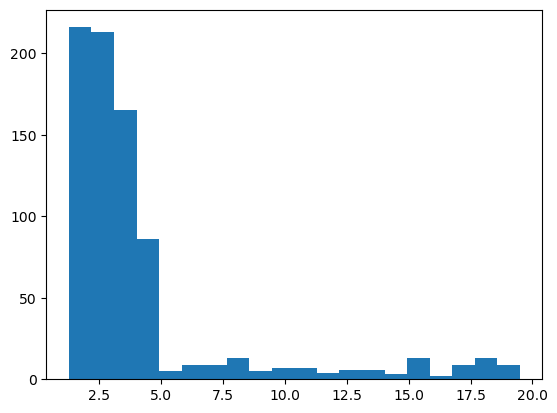

In [30]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_grad.cv_results_["mean_test_score"]==grid_cv_grad.best_score_)
print('Best mean_train_score:', grid_cv_grad.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_grad.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
grad_results_df = pd.DataFrame({'mean_train_score': grid_cv_grad.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_grad.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
grad_results_df['ratio'] = grad_results_df['mean_train_score']/grad_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = grad_results_df['ratio'].quantile(0.25)
Q3 = grad_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = grad_results_df[(grad_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (grad_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
grad_results_df = grad_results_df[~grad_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(grad_results_df['ratio'], bins=20)
plt.show()

**Interpretation**

The ratio of train kappas to test kappas using our "best" set of parameters was 1.4868. This seems like it might correspond to overfitting. But it seems in line with the (non-outlier) ratios among all tested sets of hyperparameters.

**Tuning the Gradiant Boosting Regressor for sii**

In [31]:
param_grid = {
    'grad__learning_rate': [0.5, 0.1, 0.05],
    'grad__max_depth': [3,5,7],
    'grad__max_features': [10, 15, 20, 25],
    'grad__min_samples_leaf': [5, 8, 11],
    'grad__min_samples_split': [3, 5, 7],
    'grad__n_estimators': [50, 100, 200]
}

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)


# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Instantiate a gradient boosting regressor pipeline
grad_pipe_sii = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('over', oversample),
                ('grad', GradientBoostingRegressor())])

grid_cv_grad_sii = GridSearchCV(grad_pipe_sii, 
                          param_grid = param_grid, 
                          scoring = kappa_scorer,
                          cv = 5,
                          return_train_score=True)

grid_cv_grad_sii.fit(train_cleaned[predictors], train_cleaned['sii'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x305cc5800>)),
                                       ('over',
                                        SMOTE(sampling_strategy={0: 1228,
                                                                 1: 619, 2: 315,
                                                                 3: 128})),
                                       ('grad', GradientBoostingRegressor())]),
             param_grid={'grad__learning_rate': [0.5, 0.1, 0.05],
                         'grad__max_depth': [3, 5, 7],
                         'grad__max_features': [10, 15, 20, 25],
                         'grad__min_samples_leaf': [5, 8, 11],
                         'grad__min_samples_split': [3, 5, 7],
                         'grad__n_estimators': [50, 100, 200]},
             return_train_score=True,
             scoring=make_scorer(sii_kappa, response_method='predict'))

In [32]:
# Report the results
print('Best parameters:',grid_cv_grad_sii.best_params_)
print('Best score:',grid_cv_grad_sii.best_score_)

Best parameters: {'grad__learning_rate': 0.1, 'grad__max_depth': 3, 'grad__max_features': 10, 'grad__min_samples_leaf': 5, 'grad__min_samples_split': 3, 'grad__n_estimators': 200}
Best score: 0.42962528256851173


**Tuning Results**

First run:
* 'grad__learning_rate': 0.1
* 'grad__max_depth': 3
* 'grad__max_features': 8
* 'grad__min_samples_leaf': 8
* 'grad__min_samples_split': 2
* 'grad__n_estimators': 100

Second run:
* learning_rate: 0.1
* max_depth: 3
* max_features: 10
* min_samples_leaf: 5
* min_samples_split: 3
* n_estimators: 200

These results suggest similar things as the tuning for PCIAT

In [33]:
# Check for overfitting

print(grid_cv_grad_sii.cv_results_.keys())
print(grid_cv_grad_sii.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_grad_sii.cv_results_["mean_test_score"].shape)

print(grid_cv_grad_sii.cv_results_["mean_train_score"])
print(grid_cv_grad_sii.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_grad__learning_rate', 'param_grad__max_depth', 'param_grad__max_features', 'param_grad__min_samples_leaf', 'param_grad__min_samples_split', 'param_grad__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(972,)
(972,)
[0.71809917 0.84212878 0.95437639 0.71812869 0.84101903 0.95124568
 0.71574246 0.83170415 0.95493556 0.7009812  0.82779324 0.9490779
 0.71038672 0.82819787 0.94720051 0.7157688  0.82343466 0.94244469
 0.70236363 0.8183629  0.9398316  0.70189525 0.81698501 0.94304344
 0.69717619 0.81730718 0.93921291 0.7245618  0.85179193 0.96262698
 0.72395122 0.84529545 0.96461742 0.73253037 0.84657392 0.96302085
 0.71913

Best mean_train_score: [0.69634385]
Best mean_test_score: [0.42962528]


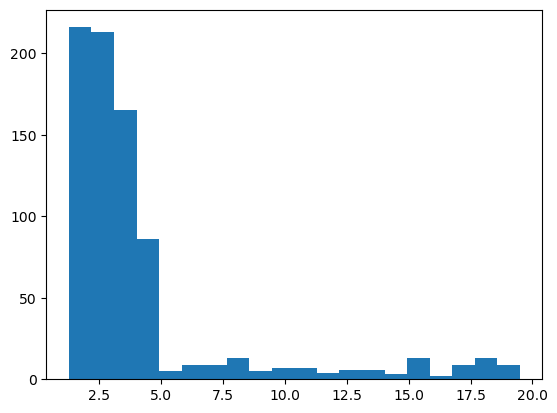

In [34]:
# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_grad_sii.cv_results_["mean_test_score"]==grid_cv_grad_sii.best_score_)
print('Best mean_train_score:', grid_cv_grad_sii.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_grad_sii.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
grad_sii_results_df = pd.DataFrame({'mean_train_score': grid_cv_grad_sii.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_grad_sii.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
grad_sii_results_df['ratio'] = grad_sii_results_df['mean_train_score']/grad_sii_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = grad_sii_results_df['ratio'].quantile(0.25)
Q3 = grad_sii_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = grad_sii_results_df[(grad_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (grad_sii_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
grad_sii_results_df = grad_results_df[~grad_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(grad_sii_results_df['ratio'], bins=20)
plt.show()

**Interpretation**

The ratio of train kappas to test kappas using our "best" set of parameters was 1.6208. This seems like it might correspond to overfitting. But it seems in line with the (non-outlier) ratios among all tested sets of hyperparameters.

**Manually Tuning Logistic Regression Inside an Ordinal Classifier**

GridSearchCV doesn't seem to be able to pass parameter values into a model wrapped in an ordinal classifier. So we'll tune this manually.

We're only going to do this for logistic regression (for now) due to time constraints. But a next step would be to do it for gradient boosting inside an ordinal classifier

In [35]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

## import kfold
from sklearn.model_selection import StratifiedKFold

# Create a custom scorer that first rounds the values of sii and then applies a cohen_kappa_score
def sii_kappa(y_true, y_pred):
    y_pred_round = np.round(y_pred)
    return cohen_kappa_score(y_true, y_pred_round, weights='quadratic')

kappa_scorer = make_scorer(sii_kappa)

siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

## set the number of CV folds
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, shuffle=True)

C_params = [0.001,0.01,0.1,0.5, 1,5, 10,20, 50, 70, 100, 150, 200]

lr_test_kappas = np.zeros((n_splits, len(C_params)))
lr_train_kappas = np.zeros((n_splits, len(C_params)))

for i,(train_index, test_index) in enumerate(kfold.split(train_cleaned[predictors], train_cleaned['sii'])):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    # Do the duplication here

    for j, cval in enumerate(C_params):
        #print(i,j)
        ordinal_logistic_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
            ('add_zones', FunctionTransformer(zone_encoder)),
            ('over', oversample),
            ('scale', StandardScaler()),
            ('logistic_oc', OrdinalClassifier(LogisticRegression(max_iter=1000, C=cval)))])
                                        
        ordinal_logistic_pipe.fit(train_tt[predictors], train_tt['sii'])
        
        pred_test = ordinal_logistic_pipe.predict(train_ho[predictors])
        pred_train = ordinal_logistic_pipe.predict(train_tt[predictors])
        
        lr_test_kappas[i,j] = sii_kappa(train_ho['sii'],  pred_test)
        lr_train_kappas[i,j] = sii_kappa(train_tt['sii'],  pred_train)

In [36]:
# Get optimal value of C
max_index = np.unravel_index(np.argmax(np.mean(lr_test_kappas, axis=0)), 
                                       np.mean(lr_test_kappas, axis=0).shape)


print(C_params[max_index[0]])

100


**Best parameters**

We have run the logistic-in-ordinal loop several times and the "optimal" value of C appears to vary quite a bit.

**Check for Overfitting**

In [37]:
# Compare kappas
mean_test_kappas = np.mean(lr_test_kappas, axis=0)
mean_train_kappas = np.mean(lr_test_kappas, axis=0)
print('Means of C-values of', C_params,'for test set are',mean_test_kappas)
print('Means of C-values of', C_params,'for train set are',mean_train_kappas)

Means of C-values of [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 100, 150, 200] for test set are [0.17680043 0.36780617 0.37241579 0.38013313 0.38252283 0.39055904
 0.38868231 0.38303997 0.3933233  0.39050204 0.40019627 0.39185387
 0.37875083]
Means of C-values of [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 70, 100, 150, 200] for train set are [0.17680043 0.36780617 0.37241579 0.38013313 0.38252283 0.39055904
 0.38868231 0.38303997 0.3933233  0.39050204 0.40019627 0.39185387
 0.37875083]


**Interpretation**

The kappa values for the train and test sets are identical.

**Retesting with Optimized Parameters**

We'll use the models generated above through the tuning process to compare with our original candidates and against each other.

We note that the models above were all models for regression rather than classification. So for the models we're using inside the ordinal classifiers, we'll manually input the best parameters.

In [ ]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import Pipeline
from OrdinalClassifier import *

# Create classifiers to use as inputs to ordinal classifiers

logisticc = LogisticRegression(max_iter=1000, C=100)
gradc = GradientBoostingClassifier()
gradc_pciat = GradientBoostingClassifier(learning_rate=0.05, max_depth= 3, max_features= 15, min_samples_leaf= 11, min_samples_split= 6, n_estimators= 100)
gradc_sii = GradientBoostingClassifier(learning_rate=0.1, max_depth= 3, max_features= 8, min_samples_leaf= 8, min_samples_split= 2, n_estimators= 100)
xgbc = XGBClassifier()


models = {
'slr_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', ['PreInt_EduHx-computerinternet_hoursday'])], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_key_pipe' : Pipeline([
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())]),

'mlr_all_pipe' : Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', predictors_less)], remainder="drop")),
                ('linear', LinearRegression())]),

'rf': RandomForestRegressor(),
'rf_pciat': RandomForestRegressor(max_depth=5, min_samples_split= 4, n_estimators=200),
'rf_sii': RandomForestRegressor(max_depth=6, min_samples_split= 2, n_estimators=100),

'ada' : AdaBoostRegressor(),

'grad' : GradientBoostingRegressor(),
'grad_pciat': GradientBoostingRegressor(learning_rate=0.1, max_depth= 3, max_features= 10, min_samples_leaf= 8, min_samples_split= 3, n_estimators= 50),
'gradc_sii' : GradientBoostingRegressor(learning_rate=0.1, max_depth= 3, max_features= 8, min_samples_leaf= 8, min_samples_split= 2, n_estimators= 100),

'xgb': XGBRegressor(),

'ordinal_logistic_pipe' : Pipeline([
                ('scale', StandardScaler()),
                ('logistic_oc', OrdinalClassifier(logisticc))]),

'ordinal_grad': OrdinalClassifier(gradc),
'ordinal_grad_pciat': OrdinalClassifier(gradc_pciat),
'ordinal_grad_sii': OrdinalClassifier(gradc_sii),

'ordinal_xgb': OrdinalClassifier(xgbc)

}

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from imblearn.over_sampling import SMOTE

# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

# Set up a list of the models and methods to organize the computation of means in the kfold split
modellist = []
for pipeline_name, pipeline_obj in models.items():
    modellist.append(pipeline_name)

methodlist = ['Compute SII from PCIAT (Standard Bins) (kappa)', 
                'Compute SII from PCIAT (Modified Bins) (kappa)',
                'Predict SII (rounded) (kappa)']

num_splits = 5

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((len(methodlist), len(modellist), num_splits))

#Make a StratifiedKFold object stratified by the variable sii
# This is necessary due to the small number of sii=3 values
kfold = StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0
for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    #The next four lines will use SMOTE to oversample 
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    # j will enumerate the model
    j=0

    for pipeline_name, pipeline_obj in models.items():
        # The ordinal predictors can't predict PCIAT scores, so we'll leave them out of the first round of computations
        if 'ordinal' in pipeline_name:
            kappa_sii_comp = 0
            kappa_sii_comp_mod = 0
        else:
            # Fit and make predictions of PCIAT_Total
            pipeline_obj.fit(X[predictors_less], X['PCIAT-PCIAT_Total'])
            pred = pipeline_obj.predict(train_ho[predictors_less])

            # Compute sii based on PCIAT
            bins = [0, 30, 49,79,100]
            pred_bin = np.digitize(pred, bins)-1

            # Try a slightly different set of bins suggested by the "tuning" below
            bins_mod = [0, 27, 39, 79, 100]
            pred_bin_mod = np.digitize(pred, bins_mod)-1

            # Compute kappa values
            kappa_sii_comp = cohen_kappa_score(train_ho['sii'], pred_bin, weights='quadratic')
            kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
        
        # Store the kappa values in the output array
        output[0,j,i] = kappa_sii_comp
        output[1,j,i] = kappa_sii_comp_mod
        j=j+1

    j=0
    for pipeline_name, pipeline_obj in models.items():
        # Fit and make predictions of sii
        pipeline_obj.fit(X[predictors], y)
        pred = pipeline_obj.predict(train_ho[predictors])

        # Round the predictors to compute kappa
        pred_round = np.round(pred)

        # Compute and record the kappa values
        kappa_sii_round = cohen_kappa_score(train_ho['sii'], pred_round, weights='quadratic')

        output[2,j,i] = kappa_sii_round
        j=j+1
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_tuned_avg = np.mean(output, axis=2)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [18]:
# create a data frame from output using modellist as the names of the columns and methodlist as the names of the rows
output_tuned_df = pd.DataFrame(output_tuned_avg, columns=modellist, index=methodlist)

output_tuned_df

,slr_pipe,mlr_key_pipe,mlr_all_pipe,rf,rf_pciat,rf_sii,ada,grad,grad_pciat,gradc_sii,xgb,ordinal_logistic_pipe,ordinal_grad,ordinal_grad_pciat,ordinal_grad_sii,ordinal_xgb
Compute SII from PCIAT (Standard Bins) (kappa),0.273194,0.434728,0.348193,0.403914,0.412772,0.426744,0.377264,0.403243,0.409499,0.410318,0.356853,0.000000,0.000000,0.000000,0.000000,0.000000
Compute SII from PCIAT (Modified Bins) (kappa),0.301702,0.444401,0.383093,0.419950,0.429164,0.424323,0.396684,0.437358,0.448010,0.444204,0.368767,0.000000,0.000000,0.000000,0.000000,0.000000
Predict SII (rounded) (kappa),0.280164,0.411745,0.333130,0.389833,0.407565,0.405852,0.199699,0.405979,0.410163,0.399711,0.348015,0.289887,0.392171,0.416182,0.416411,0.374339


**Model Selection Results**

The largest kappa scores were from predicting PCIAT and then using modified bins to compute sii values. The best results all came from gradient boosting (using the PCIAT tuned parameters increased performance slightly, but not too much). However, using the keyfeatures with linear regression was close behind, followed by the tuned random forest.

When predicting PCIAT using the standard bins, the best result came from using linear regression with keyfeatures, followed by using gradient boosting tuned for sii prediction.

When predicting sii directly, the best results came from gradient boosting within an ordinal classifier (tuned for predicting sii), followed by non-ordinal (untuned) gradient boosting, and then tuned gradient boosting and linear regression with keyfeatures.

For the purposes of the Erdos Institute project, we will pick gradient boost, predicting PCIAT and then modified bins for sii score, as a final model. (For the purposes of the Kaggle competition, these results suggest to us multiple models in the running, all of them worthy of a submission.)